In [1]:
import sys
sys.path.append('../../build')
import cv2 as cv
import numpy as np
import libry as ry
import time
import math
import random
# from perception import find_ball
#print(cv.__version__)

In [2]:
from environment import *
env = Environment(ry, math, np, time, random)

Update thrower position
*** Duplicate key found in your layout -y- ***
*** Replaced new key with -y-0 ***


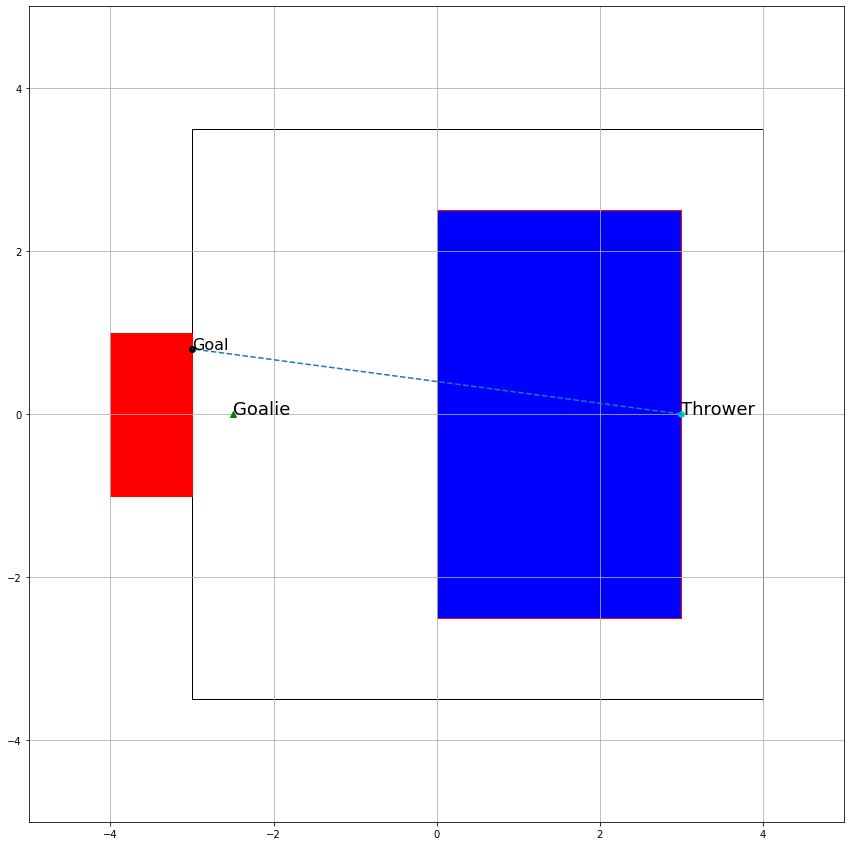

Move thrower to initial position
Reset ball position
Move above the ball
Picking up the ball


In [ ]:
#Environment initialization
env.start()

# Start gui
#posx, posy = thrower_gui(env, 0)

# Throw and block
env.throw_and_block(options={
    "Thrower1": {
        "algorithm": 2,
        "get_thrower_position_using": "gui",
        "change_thrower_position_smoothly": True,
        "reset_with_random_position": True,
        "loop": True
    }
})